# Think Bayes: Chapter 15

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from itertools import product
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb

'Done'

'Done'

## Unseen Species Problem

1. Based on the number of species observed, estimate the total number of species in the environment.
2. Estimate the prevalance of each species; that is, the fraction of the total population belonging to each species.
3. Estimate how many new species we are likely to observe when collecting new samples.
4. Estimate the number of additional reads needed to increase fraction of observed species to a given threshold.

## Lions, Tigers, Bears; Dirichlet distribution

- Each animal has a prevalance and you're equally likely to observe each type of animal.
- The prevelance maps to a probability, such that $P(L) + P(T) + P(B) = 1$.
- We are interested in modeling the joint distribution of $P(L), P(T), P(B)$.
- The Dirichlet distribution is the multi-dimensional generalization of the beta distribution: instead of two possible outcomes, it handles any number of outcomes.
- With $n$ possible outcomes, the Dirichlet distribution is parameterized by $n$ parameters, $\alpha_1 ... \alpha_n$.

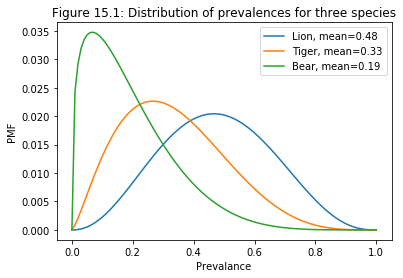

In [2]:
class Animals(mtb.PMF):
    
    def __init__(self, n=3):
        super().__init__(np.arange(n), np.ones(n))
        
    def update(self, data):
        self[:] += data
    
    def marginal(self, i):
        hypos = np.linspace(0, 1, 101)
        probs = stats.beta.pdf(hypos, self[i], self.sum() - self[i])
        return mtb.PMF(hypos, probs)
        
names = ['Lion', 'Tiger', 'Bear']
a = Animals()
a.update([3, 2, 1])

for i in range(len(a)):
    mrg = a.marginal(i)
    mrg.plot(label='%s, mean=%.2lf' % (names[i], mrg.expectation()))

plt.title("Figure 15.1: Distribution of prevalences for three species")
plt.xlabel('Prevalance')
plt.ylabel('PMF')
plt.legend()
plt.show()

## Estimating number of species

Hierarchical model:
    - level one: hypotheses about the number of species
    - level two: hypotheses about the prevalance of species given each number

CPU times: user 728 ms, sys: 0 ns, total: 728 ms
Wall time: 727 ms


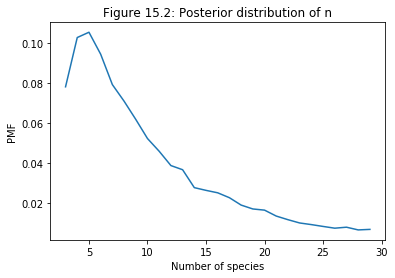

In [3]:
class Dirichlet(object):
    
    def __init__(self, n):
        self.alpha = np.ones(n)
        
    def update(self, data):
        self.alpha[:len(data)] += data
    
    def likelihood(self, data, size=1):
        m = len(data)
        if len(self.alpha) < m:
            return 0
        x = data
        p = stats.dirichlet.rvs(alpha=self.alpha, size=size)
        q = p[:,:m]**x
        return q.prod(axis=1).sum()
        
    def __repr__(self):
        return 'Dirichlet, n=%d' % len(self.alpha)
    
class SpeciesCount(mtb.PMF):
    """PMF for the n, the number of species.
    
    # Arguments:
        N: vector of possible values for n.
    
    """
    
    def __init__(self, N):
        super().__init__(hypos=N)
        self.dirichlets = {h:Dirichlet(h) for h in self.hypos}
        
    def update(self, data):
        """Hierarchical update.
        
        Updates self first, then dirichlets for each value of n.
        
        # Arguments:
            data: vector of the number of each species observed.
        
        """
        # Call the default update() method on self - maybe confusing.
        mtb.PMF.update(self, data)
        
        # Update each of the dirichlets with the new data.
        for hypo in self.hypos:
            self.dirichlets[hypo].update(data)
            
    def likelihood(self, data, hypo):
        """Likelihood P(data | hypo) = P(observed species counts | total species count).
        
        Uses the dirichlet corresponding to the hypothesized species count to compute
        the likelihood of observing this data via random sampling. Adjusts this using
        the binomial coefficient (n k), where n is the number of possible species
        under the dirichlet, and k is the number of species observed.
        """
        dirichlet = self.dirichlets[hypo]
        like = dirichlet.likelihood(data, size=8000)
        bino = nCk(len(dirichlet.alpha), len(data))
        return bino * like
        
sc = SpeciesCount(N=np.arange(3, 30))
%time sc.update(np.array([1, 2, 3]))

sc.plot()
plt.title('Figure 15.2: Posterior distribution of n')
plt.xlabel('Number of species')
plt.ylabel('PMF')
plt.show()